In [1]:
import math
import numpy as np
import torch

import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

# Character-level language modeling 

- each character of every name is trated as an example
- predict the next sequence of character

**plan:**
- start with characters
- then words
- then images

In [2]:
words = open('names.txt', 'r').read().splitlines()
words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [3]:
print("Total number of words: ", len(words))
print("Shortest word length: ", min(len(word) for word in words))
print("Longest word length: ", max(len(word) for word in words))

Total number of words:  32033
Shortest word length:  2
Longest word length:  15


## Bigram Langauge Model - two characters at a time
- Given a character, predict the next character

lets create bigrams of the usernames

In [4]:
for word in words[:2]:
    print("for the word: ", word)
    for char1, char2 in zip(word, word[1:]):
        print(char1, char2)

for the word:  emma
e m
m m
m a
for the word:  olivia
o l
l i
i v
v i
i a


lets take example of the first word, __'emma'__, 

the word starts with __'e'__ and ends with __'a'__ but the above bigrams don't capture that information, so lets add that information

In [5]:
#BOS - beginning of sentence or word in this case
#EOS - end of sentence or word in this case

for word in words[:1]:
    print("for the word: ", word)
    chars = ['<BOS>'] + list(word) + ['<EOS>']
    for char1, char2 in zip(chars, chars[1:]):
        print(char1, char2)

for the word:  emma
<BOS> e
e m
m m
m a
a <EOS>


Counting is the simplest way to determine which characters are likerly to follow other characters in Bigram Models

- How often do the bigram combinations occur?

In [6]:
freq = {}

for word in words:
    chars = ['<BOS>'] + list(word) + ['<EOS>']
    for char1, char2 in zip(chars, chars[1:]):
        bigram = (char1, char2)
        freq[bigram] = freq.get(bigram, 0) + 1

which bigrams are most frequent in our dataset?

In [7]:
sorted(freq.items(), key = lambda key_value: -key_value[1])[:5]

[(('n', '<EOS>'), 6763),
 (('a', '<EOS>'), 6640),
 (('a', 'n'), 5438),
 (('<BOS>', 'a'), 4410),
 (('e', '<EOS>'), 3983)]

wouldn't it be better to see the frequencies in a table-like format? 

2D arrays can help OR tensors(for efficient handling)

how many rows and columns should the have?

26 chars of the English language, BOS and EOS(can use a single character as well) => 27 rows and 27 columns

In [8]:
counts = torch.zeros((27, 27), dtype= torch.int32)

the tensor 'counts' needs int values but we have char literals to lets create a lookup table to map them to an int value

In [9]:
chars = list('abcdefghijklmnopqrstuvwxyz')
# stoi_lookups - from string to int
stoi_lookups = {c: i+1 for i, c in enumerate(chars)}
stoi_lookups['.'] = 0

# itos_lookups - int to string
itos_lookups = {i: char for char, i in stoi_lookups.items()}

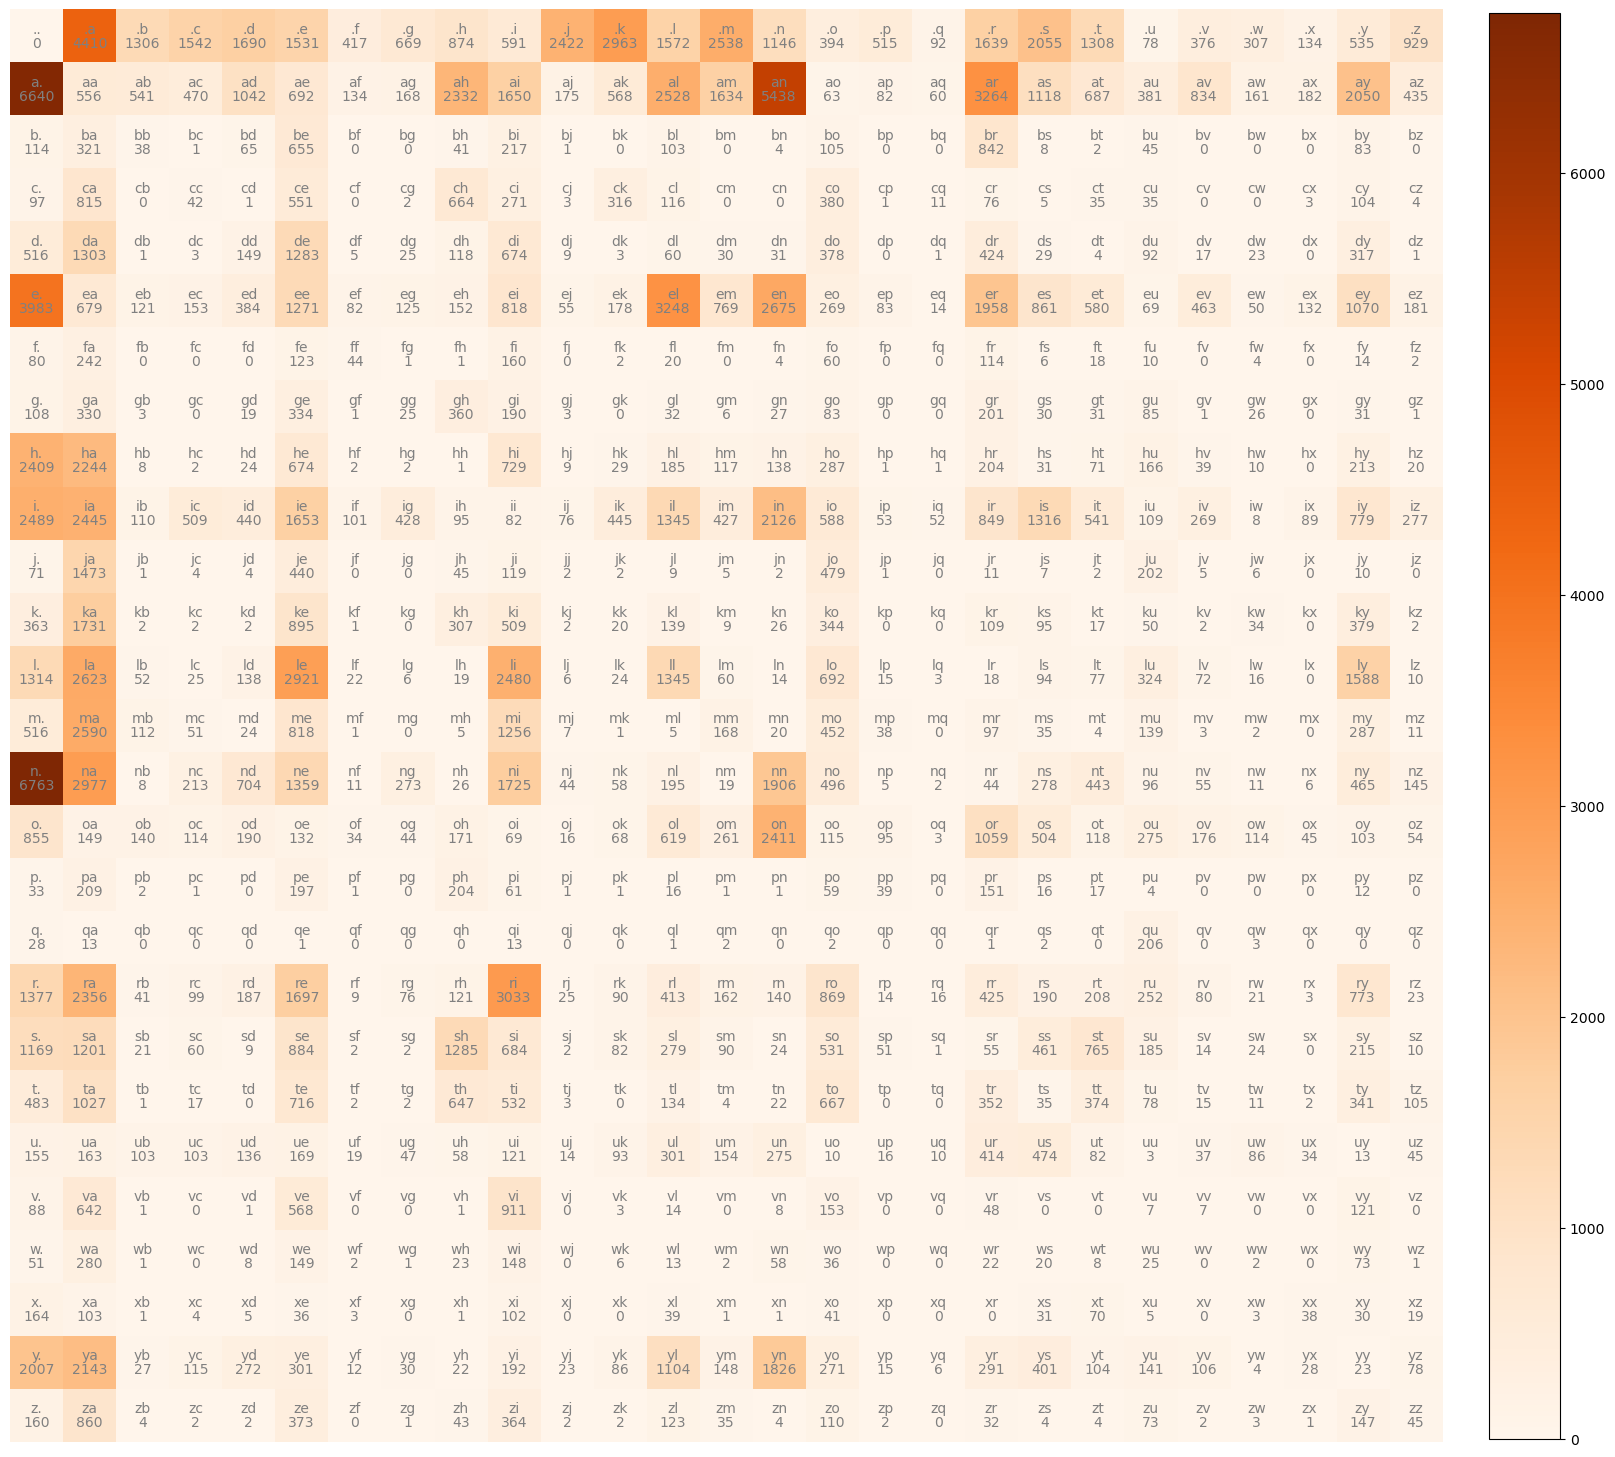

In [10]:
for word in words:
    chars = ['.'] + list(word) + ['.']
    for char1, char2 in zip(chars, chars[1:]):
        i_char1, i_char2 = stoi_lookups[char1], stoi_lookups[char2]
        counts[i_char1, i_char2] += 1

fig, ax = plt.subplots(figsize=(20, 20))
iax = plt.imshow(counts, cmap='Oranges')

for i in range(len(stoi_lookups)):
    for j in range(len(stoi_lookups)):
        biggram_str = itos_lookups[i] + itos_lookups[j]
        biagram_freq = counts[i, j].item()
        ax.text(j, i, biggram_str, ha='center', va='bottom', color='gray')
        ax.text(j, i, biagram_freq, ha='center', va='top', color='gray')

plt.axis('off')
fig.colorbar(iax, fraction=0.046, pad=0.03)

plt.show()

Remember  __We are trying to generate more of what we have__

### Sampling from the model

Lets say we are trying to decide what a word should start with, look at the first row to understand which letter occurs at the start of word frequently. 

But this only gives us the frequency, not the probability so lets calculate that.

In [11]:
freq_ = counts[0].float()
p = freq_/freq_.sum()
p

tensor([0.0000, 0.1377, 0.0408, 0.0481, 0.0528, 0.0478, 0.0130, 0.0209, 0.0273,
        0.0184, 0.0756, 0.0925, 0.0491, 0.0792, 0.0358, 0.0123, 0.0161, 0.0029,
        0.0512, 0.0642, 0.0408, 0.0024, 0.0117, 0.0096, 0.0042, 0.0167, 0.0290])

In [12]:
# manual seeding to obtain the same result no matter when and where the code is ran
g = torch.Generator().manual_seed(2147483647)
i_char = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
itos_lookups[i_char]

'c'

In [13]:
# optimized way
P = counts.float()
P /= P.sum(1, keepdim=True)

In [14]:
# manual_seed for deterministic ouptut
g = torch.Generator().manual_seed(2147483647)

for _ in range(5):
    i = 0
    names = []
    while True:
        p = P[i]
        i = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        # print(itos_lookups[i])
        names.append(itos_lookups[i])
        if i == 0: # end token
            break
    print(''.join(names))

cexze.
momasurailezitynn.
konimittain.
llayn.
ka.


### Performance Evaluation of the Bigram Model - Training Loss

In [15]:
for word in words[:2]:
    chars = ['.'] + list(word) + ['.']
    for char1, char2 in zip(chars, chars[1:]):
        i_char1, i_char2 = stoi_lookups[char1], stoi_lookups[char2]
        prob = P[i_char1, i_char2]
        print(f'{char1}{char2}: {prob:.4f}')

.e: 0.0478
em: 0.0377
mm: 0.0253
ma: 0.3899
a.: 0.1960
.o: 0.0123
ol: 0.0780
li: 0.1777
iv: 0.0152
vi: 0.3541
ia: 0.1381
a.: 0.1960


since we have 27 characters, the probability that any character would be folowed by any other character is 1/27 = 0.037 so anything below this is an indication that the bigram model has learnt something

### [Maximum Likelihood Distribution(MLE)](https://en.wikipedia.org/wiki/Maximum_likelihood_estimation)

In [16]:
prod = 1

for word in words[:2]:
    chars = ['.'] + list(word) + ['.']
    for char1, char2 in zip(chars, chars[1:]):
        i_char1, i_char2 = stoi_lookups[char1], stoi_lookups[char2]
        prob = P[i_char1, i_char2]
        # likelihood - product of all the probs
        prob_log = torch.log(prob)
        prod *= prob
        print(f'{char1}{char2}: {prob:.4f}')
prod

.e: 0.0478
em: 0.0377
mm: 0.0253
ma: 0.3899
a.: 0.1960
.o: 0.0123
ol: 0.0780
li: 0.1777
iv: 0.0152
vi: 0.3541
ia: 0.1381
a.: 0.1960


tensor(8.6369e-14)

the likelihood i.e product of all the probabilities 8.6369e-14 is a very small number, making it very inconvenient to work with thats why log likelihood is used

In [17]:
log_likelihood = 0.0
n = 0 

for word in words:
    chars = ['.'] + list(word) + ['.']
    for char1, char2 in zip(chars, chars[1:]):
        i_char1, i_char2 = stoi_lookups[char1], stoi_lookups[char2]
        prob = P[i_char1, i_char2]
        prob_log = torch.log(prob)
        # likelihood - product of all the probs i.e sum of all the log probabilities
        log_likelihood += prob_log
        n += 1
        # print(f'{char1}{char2}: {prob:.4f}{prob_log:.4f}')

negative_ll = - log_likelihood

print(f'{log_likelihood=}')
print(f'{negative_ll=}')
print(f'{negative_ll/n}')

log_likelihood=tensor(-559891.7500)
negative_ll=tensor(559891.7500)
2.454094171524048


Average negative log likelihood is used for evaluating the model, the lower the value the better the model performance!

## Neural Net Approach

- create the training set of all the bigrams, given the character x, what will be the next character y?
**xy is the bigram**

INPUTS and OUTPUTS for training

In [18]:
x_s, y_s = [], []

for word in words[:1]:
    chars = ['.'] + list(word) + ['.']
    for char1, char2 in zip(chars, chars[1:]):
        i_char1, i_char2 = stoi_lookups[char1], stoi_lookups[char2]
        print(f'{char1, char2}')
        x_s.append(i_char1)
        y_s.append(i_char2)

x_s = torch.tensor(x_s)
y_s = torch.tensor(y_s)

print(f'{x_s, y_s}')

('.', 'e')
('e', 'm')
('m', 'm')
('m', 'a')
('a', '.')
(tensor([ 0,  5, 13, 13,  1]), tensor([ 5, 13, 13,  1,  0]))


How do we create the NN now? What do we feed to it?

We have indices but doesnt make sense to feed indices to the NN, lets encode them using One-Hot encoding

- **One Hot Encoding** will create a vector for each index(representing the index of the letter)

- lets take the index 5 for example, one hot encoding will create a vector where the 5th dimension will be 1 and the rest will be 0s!

In [19]:
# make sure to cast it to float because we can't feed ints to the NN
x_enc = F.one_hot(x_s, num_classes=27).float()

NN starting with a single neuron as usual

In [20]:
# Single neuron with 27 dimensions to match the vector dimensions of the input x

w = torch.randn((27, 1)) # normal distribution of weights
print(f'{x_enc.shape, w.shape}') # (torch.Size([5, 27]), torch.Size([27, 1]))

(torch.Size([5, 27]), torch.Size([27, 1]))


the shapes of x_enc and w are [5, 27] and [27, 1] respectively so we will have to multiply x_enc by w and not the other way around

In [21]:
# @ - matrix multiplication in pytorch
x_enc @ w

tensor([[0.3128],
        [0.1159],
        [0.4122],
        [0.4122],
        [0.3239]])

**NN with 27 neurons** - these will only have a single linear layer and no bias

In [22]:
w = torch.randn((27, 27))
x_enc @ w

tensor([[ 0.4695, -0.3542, -0.9750, -0.7057, -1.1117,  0.1973,  2.1973,  0.5272,
          1.1448, -0.3713,  1.0147,  1.0033, -0.8751,  0.0987,  0.5398,  0.7530,
          0.9162,  0.7482,  1.0609,  0.5245,  0.9800, -0.9008,  0.2092,  1.0260,
         -0.4261,  0.5284,  1.4411],
        [ 0.3264,  1.0186,  0.5054,  0.6889,  0.7335,  0.4755, -0.7794,  1.2822,
          3.2261, -0.9523,  1.2614,  0.8206,  1.4165, -0.4784, -0.1752, -1.1090,
          1.0179,  0.8633, -0.8011,  0.3764, -1.1686, -0.1454,  1.5115, -0.9273,
         -0.5567,  0.0525, -0.4397],
        [-0.6827, -0.2754,  0.6104, -0.3122,  0.2478,  0.5517, -0.7062,  0.0959,
         -1.2232,  0.3230,  1.1989, -1.5735, -1.0400,  0.2948,  1.0209,  2.3365,
          0.0739,  0.6002, -0.1835, -1.6675, -1.2598,  1.6471,  0.1077,  1.4264,
          0.0934,  1.8693,  0.4611],
        [-0.6827, -0.2754,  0.6104, -0.3122,  0.2478,  0.5517, -0.7062,  0.0959,
         -1.2232,  0.3230,  1.1989, -1.5735, -1.0400,  0.2948,  1.0209,  2.3365

**Understanding the ouput of (w*x)**

What does the above result mean? What do the values entail? Each value corresponds to an input and a neuron, and the value is the firing rate of a neuron.

for example, the firing rate for the 5th neuron of 2nd input can be found by simply accessing the value of (x_enc @ w)[2, 5]

In [23]:
(x_enc @ w)[2, 5]

tensor(0.5517)

- so far we have found the output of the single layer of NN for our inputs, these outputs are log counts or logits
- but we are trying to produce the next character y for our x.
    - we can do this by computing the probabilities of the 27 characters given x, for example given 'a', which character is more likely to occur from [a-z.]
    - we had initially gotten probabilities by computing the counts, we can do the samwe by using these logits

In [24]:
logits = x_enc @ w

# the next two lines together do what Softmax does!
counts_nn = logits.exp()
probs_nn = counts_nn / counts_nn.sum(1, keepdims=True)
probs_nn

tensor([[0.0302, 0.0133, 0.0071, 0.0093, 0.0062, 0.0230, 0.1700, 0.0320, 0.0593,
         0.0130, 0.0521, 0.0515, 0.0079, 0.0208, 0.0324, 0.0401, 0.0472, 0.0399,
         0.0546, 0.0319, 0.0503, 0.0077, 0.0233, 0.0527, 0.0123, 0.0320, 0.0798],
        [0.0203, 0.0406, 0.0243, 0.0292, 0.0305, 0.0236, 0.0067, 0.0528, 0.3689,
         0.0057, 0.0517, 0.0333, 0.0604, 0.0091, 0.0123, 0.0048, 0.0405, 0.0347,
         0.0066, 0.0213, 0.0046, 0.0127, 0.0664, 0.0058, 0.0084, 0.0154, 0.0094],
        [0.0097, 0.0145, 0.0352, 0.0140, 0.0245, 0.0332, 0.0094, 0.0210, 0.0056,
         0.0264, 0.0634, 0.0040, 0.0068, 0.0257, 0.0531, 0.1978, 0.0206, 0.0348,
         0.0159, 0.0036, 0.0054, 0.0993, 0.0213, 0.0796, 0.0210, 0.1240, 0.0303],
        [0.0097, 0.0145, 0.0352, 0.0140, 0.0245, 0.0332, 0.0094, 0.0210, 0.0056,
         0.0264, 0.0634, 0.0040, 0.0068, 0.0257, 0.0531, 0.1978, 0.0206, 0.0348,
         0.0159, 0.0036, 0.0054, 0.0993, 0.0213, 0.0796, 0.0210, 0.1240, 0.0303],
        [0.0068, 0.0151,

**Softmax Activation Function** takes the exp of logits i.e log counts and divides and normalizes(summation of the exp of logits) to **output a probability distribution**

Putting everything together for the **Forward Pass**

In [25]:
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27, 27), generator=g, requires_grad=True) # each nueron recieves 27 inputs
x_enc = F.one_hot(x_s, num_classes=27).float()

In [26]:
# forward pass
logits = x_enc @ W
counts_nn = logits.exp()
probs_nn = counts_nn / counts_nn.sum(1, keepdims=True)

# average negative log likelihood i.e loss
loss = - probs_nn[torch.arange(5), y_s].log().mean()
loss

tensor(3.7693, grad_fn=<NegBackward0>)

The **loss** is 3.76930, which is pretty high. lets optimise the NN with a backward pass

Oprimization

In [27]:
# backward pass

W.grad = None # VERY IMP: set all the gradients to 0
loss.backward()
W.data += -0.1 * W.grad

### Putting Everything together : Forward and Backward Pass for Bigram Model

In [28]:
# dataset 
x_s, y_s = [], []

for word in words:
    chars = ['.'] + list(word) + ['.']
    for char1, char2 in zip(chars, chars[1:]):
        i_char1, i_char2 = stoi_lookups[char1], stoi_lookups[char2]
        # print(f'{char1, char2}')
        x_s.append(i_char1)
        y_s.append(i_char2)

x_s = torch.tensor(x_s)
y_s = torch.tensor(y_s)
num = x_s.nelement()

print('Total Examples: ', num)

# Network Initialization

g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27, 27), generator=g, requires_grad=True) # each nueron recieves 27 inputs

Total Examples:  228146


In [29]:
for step in range(100):
    # forward pass
    x_enc = F.one_hot(x_s, num_classes=27).float()

    logits = x_enc @ W
    counts_nn = logits.exp()
    probs_nn = counts_nn / counts_nn.sum(1, keepdims=True)
    loss = - probs_nn[torch.arange(num), y_s].log().mean()
    # print("loss: ", loss.item())
    
    # backward pass
    W.grad = None
    loss.backward()

    # update the weights
    W.data += -50 * W.grad

loss

tensor(2.4729, grad_fn=<NegBackward0>)

Sampling from the NN model 

In [30]:
g = torch.Generator().manual_seed(2147483647)

for _ in range(5):
    names = []
    i = 0
    while True:
        x_curr = torch.tensor([i])

        x_enc = F.one_hot(x_curr, num_classes=27).float()
        logits = x_enc @ W
        counts_nn = logits.exp()
        probs_nn = counts_nn / counts_nn.sum(1, keepdims=True)
        
        i = torch.multinomial(probs_nn, num_samples=1, replacement=True, generator=g).item()
        # print(itos_lookups[i])
        names.append(itos_lookups[i])
        if i == 0: # end token
            break
    print(''.join(names))

cexze.
momasurailezityha.
konimittain.
llayn.
ka.


# Notes

Note 1: torch.multinomial - Returns a tensor where each row contains num_samples indices sampled from the multinomial probability distribution located in the corresponding row of tensor input.

In [31]:
# manual seeding to obtain the same result no matter when and where the code is ran
g = torch.Generator().manual_seed(2147483647)
nums = torch.rand(3, generator=g)
probs = nums/nums.sum()
probs

tensor([0.6064, 0.3033, 0.0903])

In [32]:
dist = torch.multinomial(probs, num_samples=100, replacement=True, generator=g)

In [33]:
dist

tensor([1, 1, 2, 0, 0, 2, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 2, 0, 0,
        1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1,
        0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 0, 1, 0,
        0, 1, 1, 1])

Note 2: Tensors and broadcasting

In [34]:
p = counts.float()
print("p shape: ", p.shape)

row_sum = p.sum(1, keepdim=True)
print("row_sum shape: ", row_sum.shape)

p shape:  torch.Size([27, 27])
row_sum shape:  torch.Size([27, 1])


p is 27 * 27
row_sum is 27 * 1

__Two tensors are “broadcastable” if the following rules hold:__

- Each tensor has at least one dimension.
- When iterating over the dimension sizes, starting at the trailing dimension, the dimension sizes must either be equal, one of them is 1, or one of them does not exist.

according to the broadcating rules, division of p with row_sum is possible since one of them is 1 and other is equal.

How does it work?
- when dividing p which is 27 * 27 by row_sum which is of 27 * 1, the value of the row_sum will be pasted across the entire row making it 27*27 internally and then element-wise division will be performed

Note 3: MLE

- MLE is a method of estimating the parameters of an assumed probability distribution, given some observed data. 

- This is achieved by **maximizing a likelihood function** so that, under the assumed statistical model, the observed data is most probable.

- Higher the MLE, better the model


as the probability increases the log likelihood converges towards 0 and vice versa

Text(0.5, 1.0, 'Log Likelihood for probabilities(values between 0 to 1)')

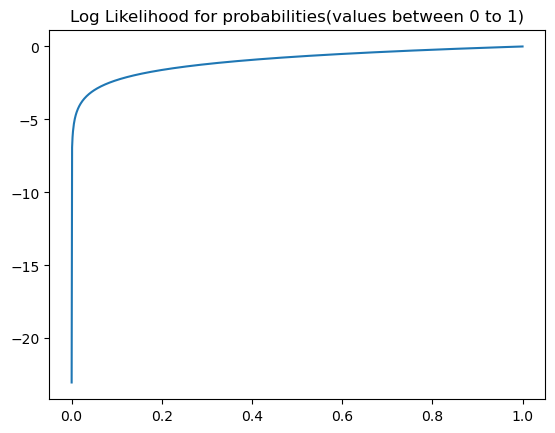

In [35]:
inp = np.linspace(1e-10, 1, 1000)
out = np.log(inp)

plt.plot(inp, out)
plt.title('Log Likelihood for probabilities(values between 0 to 1)')

 __Reference: [Neural Networks: Zero to Hero by **Anderj Karpathy**](https://youtu.be/VMj-3S1tku0?si=nt0sYb9Rs2g4qApr)__